# Trabalho Final - Versão Final

In [1]:
import pandas as pd
from pyomo.environ import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# Carregando a instancia no excel
file = 'https://github.com/KanonStarbringer/Trabalho-Final-Modelagem-com-PL-PI/raw/main/trabalho%20final.xlsx'

# Utilizando o Pandas para ler a tabela
data = pd.read_excel(file, sheet_name='Instancia 1')

# Extraindo os dados
r = data.iloc[0, 1:].tolist()  # Tempo de liberação
d = data.iloc[1, 1:].tolist()  # Duração do job
p = data.iloc[2, 1:].tolist()  # Prazo do job
w = data.iloc[3, 1:].tolist()  # Penalidade por atraso
tipo = data.iloc[4, 1:].tolist()  # Tipo do job
n = len(r)

# Calculando tmax
tmax = max(p) + max(d) + 10  # Buffer para acomodar atrasos

In [3]:
# Criando o modelo Pyomo
model = ConcreteModel()

# Definindo os conjuntos
model.J = RangeSet(n)
model.T = RangeSet(0, tmax)

# Definindo os parâmetros
model.r = Param(model.J, initialize={i+1: r[i] for i in range(n)})
model.d = Param(model.J, initialize={i+1: d[i] for i in range(n)})
model.p = Param(model.J, initialize={i+1: p[i] for i in range(n)})
model.w = Param(model.J, initialize={i+1: w[i] for i in range(n)})
model.tipo = Param(model.J, initialize={i+1: tipo[i] for i in range(n)}, within=Any)

In [4]:
# Variável de decisão (somente para t >= rj)
model.y = Var(((j, t) for j in model.J for t in model.T if t >= r[j-1]), domain=Binary)  # 1 se a tarefa j começar no tempo t, 0 caso contrário

In [5]:
# Função Objetivo
def objective_function(model):
    penalty = 0
    for j in model.J:
        for t in model.T:
            if (j, t) not in model.y.index_set():
                continue
            if t >= model.p[j] - model.d[j]:
                if t <= model.p[j] + 5 - model.d[j]:
                    penalty += model.w[j] * max(0, t - (model.p[j] - model.d[j])) * model.y[j, t]
                else:
                    penalty += (model.w[j] * 5 + 2 * model.w[j] * max(0, t - (model.p[j] + 5 - model.d[j]))) * model.y[j, t]
    return penalty

model.obj = Objective(rule=objective_function, sense=minimize)

In [6]:
# Restrição 1: Garantir que uma tarefa irá começar com a execução
def start_constraint(model, j):
    return sum(model.y[j, t] for t in model.T if t >= model.r[j] and t <= tmax - model.d[j]) == 1
model.start_constraint = Constraint(model.J, rule=start_constraint)

In [7]:
# Restrição 2: Garantir que não há sobreposição
def execution_constraint(model, t):
    return sum(model.y[j, s] for j in model.J for s in range(max(0, t - model.d[j] + 1), t + 1) if (j, s) in model.y) <= 1
model.execution_constraint = Constraint(model.T, rule=execution_constraint)

In [8]:
# Restrição 3: Intervalo de 1 dia para ajuste das máquinas quando se troca o tipo de tarefa
def setup_time_constraint(model, j1, j2, t):
    if model.tipo[j1] != model.tipo[j2] and t + model.d[j1]  <= tmax:
        if (j1, t) in model.y.index_set() and (j2, t + model.d[j1] ) in model.y.index_set():
            return model.y[j1, t] + model.y[j2, t + model.d[j1] ] <= 1
    return Constraint.Skip

model.setup_time_constraint = Constraint(model.J, model.J, model.T, rule=setup_time_constraint)

In [9]:
model.pprint()

2 RangeSet Declarations
    J : Dimen=1, Size=7, Bounds=(1, 7)
        Key  : Finite : Members
        None :   True :   [1:7]
    T : Dimen=1, Size=39, Bounds=(0, 38)
        Key  : Finite : Members
        None :   True :  [0:38]

5 Param Declarations
    d : Size=7, Index=J, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :     5
          2 :     6
          3 :     5
          4 :     4
          5 :     3
          6 :     4
          7 :     3
    p : Size=7, Index=J, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :    20
          2 :    21
          3 :    15
          4 :    10
          5 :     8
          6 :    15
          7 :    22
    r : Size=7, Index=J, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :     2
          2 :     5
          3 :     4
          4 :     0
          5 :     0
          6 :     8
          7 :     9
    tipo : Size=7, Index=J, Domain=Any, Default=None, Mutable=False
   

In [10]:
# Resolvendo o modelo
solver = SolverFactory('glpk')
results = solver.solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/f8/sx2sm28s5xn92g54_n5vypwh0000gn/T/tmp36zml61x.glpk.raw
 --wglp /var/folders/f8/sx2sm28s5xn92g54_n5vypwh0000gn/T/tmp0n327q3f.glpk.glp
 --cpxlp /var/folders/f8/sx2sm28s5xn92g54_n5vypwh0000gn/T/tmphxfyi5yr.pyomo.lp
Reading problem data from '/var/folders/f8/sx2sm28s5xn92g54_n5vypwh0000gn/T/tmphxfyi5yr.pyomo.lp'...
/var/folders/f8/sx2sm28s5xn92g54_n5vypwh0000gn/T/tmphxfyi5yr.pyomo.lp:5406: warning: lower bound of variable 'x188' redefined
/var/folders/f8/sx2sm28s5xn92g54_n5vypwh0000gn/T/tmphxfyi5yr.pyomo.lp:5406: warning: upper bound of variable 'x188' redefined
769 rows, 245 columns, 2659 non-zeros
245 integer variables, all of which are binary
5651 lines were read
Writing problem data to '/var/folders/f8/sx2sm28s5xn92g54_n5vypwh0000gn/T/tmp0n327q3f.glpk.glp'...
4630 lines were written
GLPK Integer Optimizer 5.0
769 rows, 245 columns, 2659 non-zeros
245 integer variables, all of which are bi

In [11]:
# Extraindo e imprimindo os resultados
schedule = []
for j in model.J:
    for t in model.T:
        if (j, t) in model.y and model.y[j, t].value == 1:
            schedule.append((j, t))
            break

print("Agenda (Tarefa, Dia de Início):", schedule)
total_penalty = value(model.obj)
print("Penalidade Total:", total_penalty)

Agenda (Tarefa, Dia de Início): [(1, 19), (2, 12), (3, 27), (4, 0), (5, 5), (6, 8), (7, 24)]
Penalidade Total: 80.0


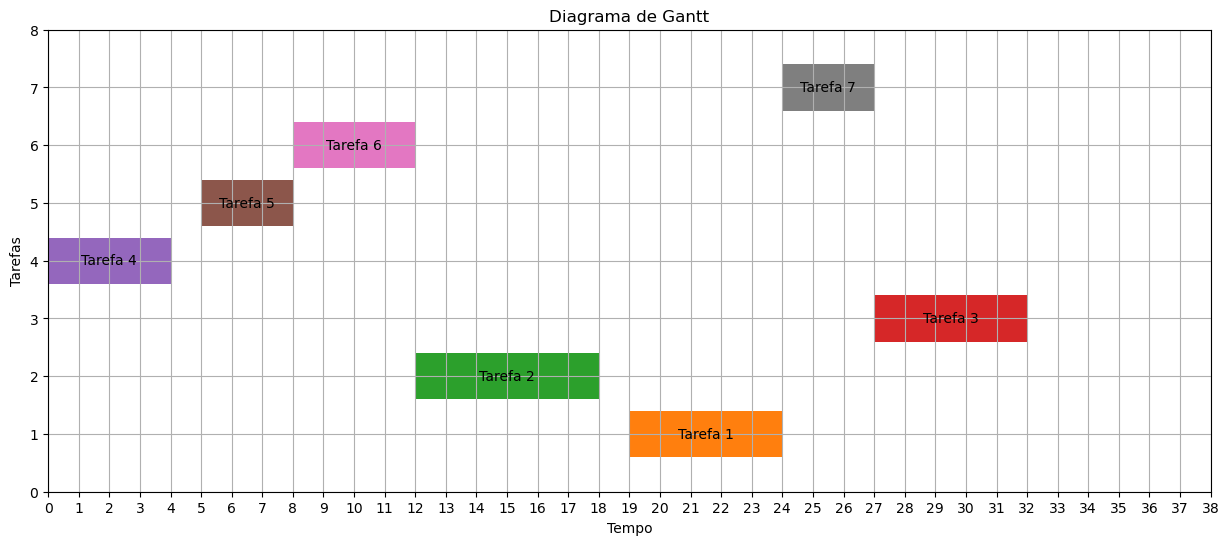

In [12]:
fig, gnt = plt.subplots(figsize=(15, 6))  # Ajustando o tamanho do gráfico

gnt.set_xlabel('Tempo')
gnt.set_ylabel('Tarefas')

# Definindo os limites do gráfico
gnt.set_xlim(0, tmax)
gnt.set_ylim(0, len(schedule) + 1)

# Adicionando barras para cada tarefa
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for (job, start) in schedule:
    gnt.broken_barh([(start, model.d[job])], (job - 0.4, 0.8), facecolors=(colors[job % len(colors)]))

# Adicionando labels
for (job, start) in schedule:
    gnt.text(start + model.d[job] / 2, job, f'Tarefa {job}', ha='center', va='center', color='black')

# Ajustando os rótulos do eixo x
gnt.set_xticks(range(tmax + 1))

# Adicionando a grade
gnt.grid(True)

plt.title('Diagrama de Gantt')
plt.show()